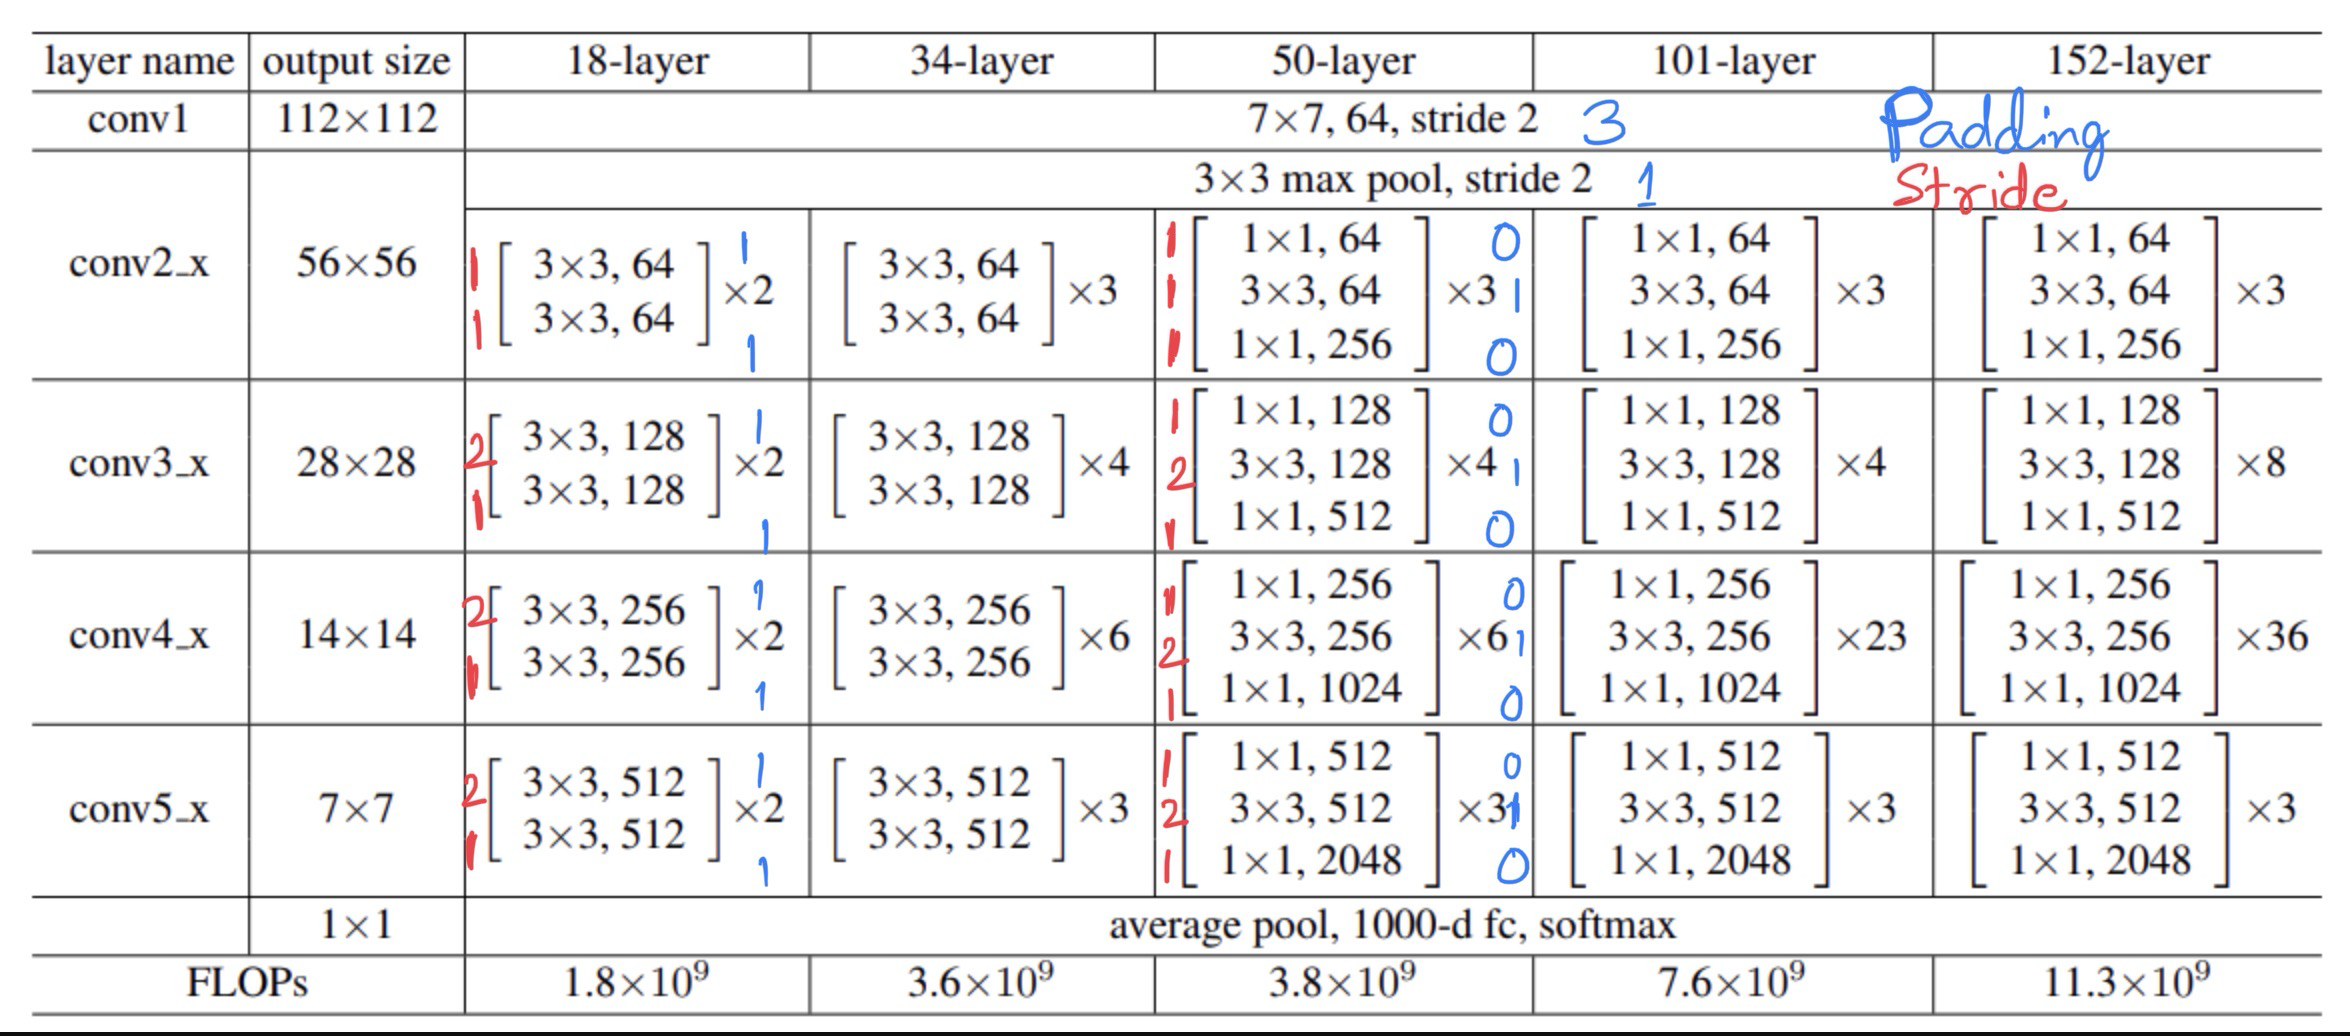
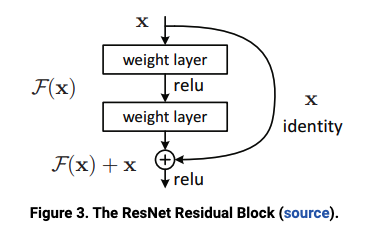

In [54]:
import torch
import torch.nn as nn
from torchsummary import summary

## ResNet

### Residual Networks (ResNet)

ResNet, short for Residual Network, is a specific type of neural network that was introduced in 2015 by Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun in their paper “Deep Residual Learning for Image Recognition”. The ResNet models were extremely successful, winning 1st place in the ILSVRC 2015 classification competition with a top-5 error rate of 3.57%. ResNet is a fully convolutional neural network with an encoder-decoder structure that has been adapted to incorporate other convolutional neural network architecture designs. The architecture of ResNet can be broadly thought of as a deep neural network with skip connections between layers that add the outputs from previous layers to the outputs of stacked layers. This results in the ability to train much deeper neural networks without running into the vanishing gradient problem. ResNet has many variants that run on the same concept but have different numbers of layers. ResNet50 is used to denote the variant that can work with 50 neural network layers. ResNet has significantly enhanced the performance of neural networks with more layers and has been used in various domains, including computer vision and biomedical imaging.

### Designing ResNet


Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385


### Residual Layer

As discussed, after two convolution operations, input of those 2 convolution is added to their output. That is what we are implementing in the below code.


* Each residual block consists of 2 convolution operations
* Convolution -> batch norm -> Relu
* Except if downsampling has to be applied then the 2nd conv layer's output is added to input before applying ReLU.

### make_block method

One of the defining characteristics of ResNet is its deep and repetitive structure, where residual blocks are stacked together in a highly modular fashion. To streamline the creation of these blocks and facilitate the assembly of the network, the `make_block` function is employed.

**Function Purpose**:
- The `make_block` function is instrumental in constructing the core building blocks of a ResNet architecture. These blocks are stacked repeatedly to form the complete network.

**Parameters**:
- `residual_layer`: This parameter corresponds to the specific type of residual block used in ResNet. Residual blocks contain skip connections and enable the network to learn residual functions.
- `inp_c`: It denotes the number of input channels (or feature maps) entering the layer, which depends on the network architecture and the previous layer.
- `out_c`: This parameter specifies the number of output channels (feature maps) that the layer should produce. It's a crucial factor in determining the network's capacity.
- `num_residual_layers_in_block`: ResNet architectures consist of multiple residual blocks within a single layer. The `num_residual_layers_in_block` parameter indicates how many times the `residual_layer` type should be repeated within the layer.
- `stride`: Stride controls the spatial downsampling applied within the layer. It determines how the layer processes input data and affects the spatial dimensions of the feature maps.

**Downsampling**:
- ResNet architectures often involve spatial downsampling to reduce feature map dimensions. Downsampling typically occurs when `stride` is not equal to 1 or when the number of output channels `out_c` differs from the number of input channels `inp_c`. In such cases, a downsampling mechanism is created using a 1x1 convolutional layer followed by batch normalization. This mechanism is added as a `downsample` module to match the dimensions.

**Layer Construction**:
- The `make_block` function initializes a list called `layers` to hold the sequence of residual blocks.
- The initial block, which may include downsampling if required, is appended to the `layers` list.
- `inp_c` is updated to match `out_c` because subsequent residual blocks within the same layer expect `out_c` channels as input.
- Additional blocks, as specified by the `num_residual_layers_in_block` parameter, are appended to the `layers` list. These blocks typically do not involve downsampling.

**Sequential Module**:
- Finally, all the residual blocks within the `layers` list are grouped together into a single sequential module using PyTorch's `nn.Sequential`. This sequential module encapsulates the entire layer, allowing it to be easily integrated into the broader ResNet architecture.

In [77]:
class block_50_101_152(nn.Module):
    def __init__(self, in_channels, intermediate_channels, identity_downsample=None, stride=1): # out_channels = 4 * in_channels 
        super().__init__()
        self.expansion = 4
        
        self.conv1 = nn.Conv2d(in_channels, intermediate_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1   = nn.BatchNorm2d(intermediate_channels)

        self.conv2 = nn.Conv2d(intermediate_channels, intermediate_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(intermediate_channels)

        self.conv3 = nn.Conv2d(intermediate_channels, intermediate_channels * self.expansion, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3   = nn.BatchNorm2d(intermediate_channels * self.expansion)
        
        self.relu  = nn.ReLU()
        self.identity_downsample   = identity_downsample
        self.stride = stride

    def forward(self, x):

        identity = x.clone()

        out = self.conv1(x)
        out = self.bn1(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        
        out += identity
        out = self.relu(out)

        return out

In [67]:
class block_18_34(nn.Module):
    def __init__(self, in_channels, intermediate_channels, identity_downsample=None, stride=1): 
        super().__init__()
               
        self.conv1 = nn.Conv2d(in_channels, intermediate_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(intermediate_channels)

        self.conv2 = nn.Conv2d(intermediate_channels, intermediate_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(intermediate_channels)
       
        self.relu  = nn.ReLU()
        self.identity_downsample   = identity_downsample
        self.stride = stride

    def forward(self, x):

        identity = x.clone()

        out = self.conv1(x)
        out = self.bn1(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        
        out += identity
        out = self.relu(out)

        return out

In [68]:
class ResNet_50_101_152(nn.Module):
    def __init__(self, block, layers, image_channel, num_classes):
        super(ResNet_50_101_152, self).__init__()
        
        self.in_channels = 64

        self.conv1   = nn.Conv2d(in_channels=image_channel, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1     = nn.BatchNorm2d(64)
        self.relu    = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.conv2_x = self._make_layer(block, layers[0], intermediate_channels=64,  stride=1)
        self.conv3_x = self._make_layer(block, layers[1], intermediate_channels=128, stride=2)
        self.conv4_x = self._make_layer(block, layers[2], intermediate_channels=256, stride=2)
        self.conv5_x = self._make_layer(block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc      = nn.Linear(512 * 4, num_classes)    


    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                                  nn.Conv2d(self.in_channels, intermediate_channels * 4, kernel_size=1, stride=stride, padding=0, bias=False),
                                  nn.BatchNorm2d(intermediate_channels * 4))
        
        layers.append(block(self.in_channels, intermediate_channels, identity_downsample, stride))

        self.in_channels = intermediate_channels * 4

        for i in range (num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))
        
        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.conv2_x(out)
        out = self.conv3_x(out)
        out = self.conv4_x(out)
        out = self.conv5_x(out)

        out = self.avgpool(out)
        
        out = torch.flatten(out, 1)
        out = self.fc(out)

        return out

In [69]:
class ResNet_18_34(nn.Module):
    def __init__(self, block, layers, image_channel, num_classes):
        super(ResNet_18_34, self).__init__()
        
        self.in_channels = 64

        self.conv1   = nn.Conv2d(in_channels=image_channel, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1     = nn.BatchNorm2d(64)
        self.relu    = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.conv2_x = self._make_layer(block, layers[0], intermediate_channels=64,  stride=1)
        self.conv3_x = self._make_layer(block, layers[1], intermediate_channels=128, stride=2)
        self.conv4_x = self._make_layer(block, layers[2], intermediate_channels=256, stride=2)
        self.conv5_x = self._make_layer(block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc      = nn.Linear(512, num_classes)    


    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        if stride != 1 or self.in_channels != intermediate_channels:
            identity_downsample = nn.Sequential(
                                  nn.Conv2d(self.in_channels, intermediate_channels, kernel_size=1, stride=stride, padding=0, bias=False),
                                  nn.BatchNorm2d(intermediate_channels))
        
        layers.append(block(self.in_channels, intermediate_channels, identity_downsample, stride))

        self.in_channels = intermediate_channels

        for i in range (num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))
        
        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.conv2_x(out)
        out = self.conv3_x(out)
        out = self.conv4_x(out)
        out = self.conv5_x(out)

        out = self.avgpool(out)
        
        out = torch.flatten(out, 1)
        out = self.fc(out)

        return out

In [70]:
x = (3, 224, 224)
ResNet18  = ResNet_18_34(block_18_34, layers=[2, 2, 2, 2],  image_channel=3, num_classes=10)
ResNet34  = ResNet_18_34(block_18_34, layers=[3, 4, 6, 3],  image_channel=3, num_classes=10)

ResNet50  = ResNet_50_101_152(block_50_101_152, layers=[3, 4, 6, 3],  image_channel=3, num_classes=10)
ResNet101 = ResNet_50_101_152(block_50_101_152, layers=[3, 4, 23, 3], image_channel=3, num_classes=10)
ResNet152 = ResNet_50_101_152(block_50_101_152, layers=[3, 8, 36, 3], image_channel=3, num_classes=10)

In [71]:
summary(ResNet18, x)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
            Conv2d-7           [-1, 64, 56, 56]          36,864
       BatchNorm2d-8           [-1, 64, 56, 56]             128
              ReLU-9           [-1, 64, 56, 56]               0
      block_18_34-10           [-1, 64, 56, 56]               0
           Conv2d-11           [-1, 64, 56, 56]          36,864
      BatchNorm2d-12           [-1, 64, 56, 56]             128
           Conv2d-13           [-1, 64, 56, 56]          36,864
      BatchNorm2d-14           [-1, 64,

In [72]:
summary(ResNet34, x)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
            Conv2d-7           [-1, 64, 56, 56]          36,864
       BatchNorm2d-8           [-1, 64, 56, 56]             128
              ReLU-9           [-1, 64, 56, 56]               0
      block_18_34-10           [-1, 64, 56, 56]               0
           Conv2d-11           [-1, 64, 56, 56]          36,864
      BatchNorm2d-12           [-1, 64, 56, 56]             128
           Conv2d-13           [-1, 64, 56, 56]          36,864
      BatchNorm2d-14           [-1, 64,

In [73]:
summary(ResNet50, x)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
            Conv2d-7           [-1, 64, 56, 56]          36,864
       BatchNorm2d-8           [-1, 64, 56, 56]             128
            Conv2d-9          [-1, 256, 56, 56]          16,384
      BatchNorm2d-10          [-1, 256, 56, 56]             512
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
             ReLU-13          [-1, 256, 56, 56]               0
 block_50_101_152-14          [-1, 256,

In [74]:
summary(ResNet101, x)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
            Conv2d-7           [-1, 64, 56, 56]          36,864
       BatchNorm2d-8           [-1, 64, 56, 56]             128
            Conv2d-9          [-1, 256, 56, 56]          16,384
      BatchNorm2d-10          [-1, 256, 56, 56]             512
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
             ReLU-13          [-1, 256, 56, 56]               0
 block_50_101_152-14          [-1, 256,

In [75]:
summary(ResNet152, x)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
            Conv2d-7           [-1, 64, 56, 56]          36,864
       BatchNorm2d-8           [-1, 64, 56, 56]             128
            Conv2d-9          [-1, 256, 56, 56]          16,384
      BatchNorm2d-10          [-1, 256, 56, 56]             512
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
             ReLU-13          [-1, 256, 56, 56]               0
 block_50_101_152-14          [-1, 256,

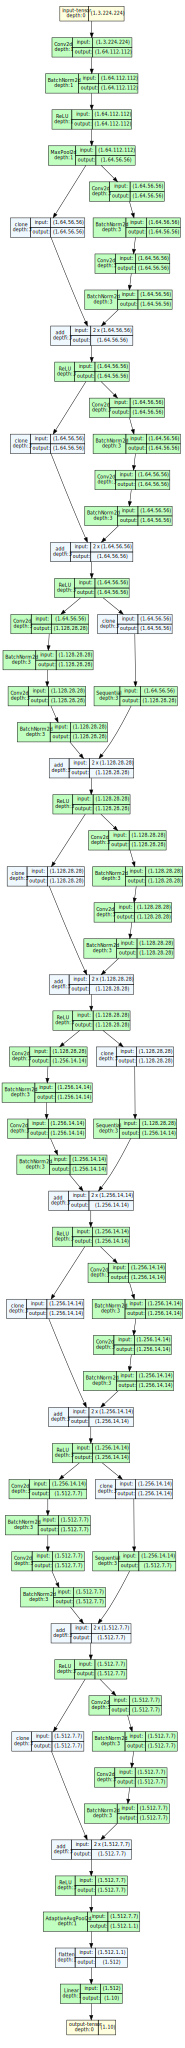

In [76]:
from torchview import draw_graph

batch_size = 1
# device='meta' -> no memory is consumed for visualization
model_graph = draw_graph(ResNet18, input_size=(batch_size, 3, 224, 224), device='meta')
model_graph.visual_graph